<a href="https://colab.research.google.com/github/abhirbhandary/Data_Engineering/blob/main/Data_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aim

1.   To Extract Data by Scraping Wikipedia
2.   To get data using API
3.   To Save the data in a database



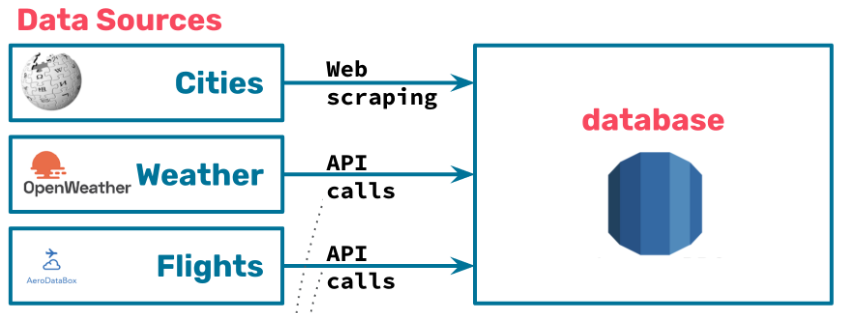

### 1. Extracting Data from Wikipedia about Franfurt.

In [ ]:
# colab has an older version of beautifulsoup by default
# here we upgrade it
# if you are working on your own computer, you can probably comment this step out and skip it
!pip install --upgrade beautifulsoup4

In [ ]:
# 1. import libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re

In [ ]:
# 2. find url and store it in a variable
url = "https://en.wikipedia.org/wiki/Frankfurt_am_Main"

In [ ]:
# 3. download html with a get request
response = requests.get(url)
response.status_code # 200 status code means OK!

In [ ]:
#headers = {'Accept-Language': 'en-US,en;q=0.8'}
#response = requests.get(url, headers = headers)

In [ ]:
# 4.1. parse html (create the 'soup')
soup = BeautifulSoup(response.content, "html.parser")
# 4.2. check that the html code looks like it should
soup

In [ ]:
# soup

In [ ]:
# 5. retrieve/extract the desired info
# let's first try to get the name of the city
# by copying the selector we can see that it has the id firstHeading (it also has a class by the same name!)
soup.select("#firstHeading")

In [ ]:
soup.select("#firstHeading")[0]

In [ ]:
soup.select("#firstHeading")[0].get_text()

In [ ]:
# here we initialise our empty dictionary for the city
response_dict = {}

# here we fill the dictionary with information using the ids, classes, and selectors that we found in the html
response_dict['city'] = soup.select(".firstHeading")[0].get_text()
response_dict['country'] = soup.select(".infobox-data")[0].get_text()
response_dict['latitude'] = soup.select(".latitude")[0].get_text()
response_dict['longitude'] = soup.select(".longitude")[0].get_text()
response_dict['Population'] = soup.select(".infobox-data")[10].get_text()

In [ ]:
# add our dictionary for the city to list_for_df
list_for_df = []
list_for_df.append(response_dict)

# make the DataFrame
cities_df = pd.DataFrame(list_for_df)

In [ ]:
  # fixing latitude
  cities_df['latitude'] = cities_df['latitude'].str.split('″').str[0].str.replace('°', '.', regex=False).str.replace('′', '', regex=False)
  # fixing longitude
  cities_df['longitude'] = cities_df['longitude'].str.split('″').str[0].str.replace('°', '.', regex=False).str.replace('′', '', regex=False)

In [ ]:
# fixing Population
cities_df['Population'] = cities_df['Population'].str.replace(',', '', regex=False)

In [ ]:
cities_df

### 2. Open Weather API for Franfurt.

In [ ]:
import json

In [ ]:
# Custom Function to get data like IPython.display in jupiter notebook
from IPython.display import HTML

def render_json(jstr):
  if type(jstr) != str:
    jstr = json.dumps(jstr)
  return HTML("""
<script src="https://rawgit.com/caldwell/renderjson/master/renderjson.js"></script>
<script>
renderjson.set_show_to_level(1)
document.body.appendChild(renderjson(%s))
new ResizeObserver(google.colab.output.resizeIframeToContent).observe(document.body)
</script>
""" % jstr)

In [ ]:
cities_df.info()

In [ ]:
cities_df

In [ ]:
cities_df = cities_df.astype({'latitude':'float','longitude':'float','Population':'int'})

In [ ]:
cities_df['city_id'] = cities_df.index
cities_df

In [ ]:
# The response from the website is stored inside the variable 'Frankfurt'.
Frankfurt = requests.get(f"https://api.openweathermap.org/data/2.5/weather?lat=50.110924&lon=8.682127&appid=#####&units=metric")
Frankfurt

In [ ]:
# Get the status code from the response.
Frankfurt.status_code

In [ ]:
# Get the text from the response.
Frankfurt.text

In [ ]:
# view the response as a JSON.
Frankfurt.json()

### 3. Day Weather for 5 Days Frankfurt -API

In [ ]:
Frankfurt = requests.get(f"https://api.openweathermap.org/data/2.5/forecast?lat=50.110924&lon=8.682127&appid=#####&units=metric")
Frankfurt

In [ ]:
weather_json = Frankfurt.json()

In [ ]:
weather_json

In [ ]:
render_json(weather_json)

In [ ]:
# we'll store the information in this dicitonary:

weather_dict = {'city':[],
                'time':[],
                'temp':[],
                'outlook':[],
                'wind_speed':[],
                'pressure':[]}

In [ ]:
# let's begin the loop
for i in weather_json['list']:
    weather_dict['city'].append(weather_json['city']['name'])
    weather_dict['time'].append(i['dt_txt'])
    weather_dict['temp'].append(i['main']['temp'])
    weather_dict['outlook'].append(i['weather'][0]['main'])
    weather_dict['wind_speed'].append(i['wind']['speed'])
    weather_dict['pressure'].append(i['main']['pressure'])

In [ ]:
weather_dict

In [ ]:
# Now we convert our dictionary to a DataFrame
weather_df = pd.DataFrame(weather_dict)
weather_df

In [ ]:
weather_df['city_id'] = 0

In [ ]:
weather_df

### 4. Airport Data for Frankfurt - API

Frankurt: latitude 50.11 longitude 8.68.

In [ ]:
import requests

url = "https://aerodatabox.p.rapidapi.com/airports/search/location/50.11/8.68/km/50/16"

querystring = {"withFlightInfoOnly":"true"}

headers = {
	"X-RapidAPI-Key": "######",
	"X-RapidAPI-Host": "aerodatabox.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

In [ ]:
response.json()

We can now turn this into a dataframe using .json_normalize()

In [ ]:
Airport_df = pd.DataFrame(pd.json_normalize(response.json()['items']))

In [ ]:
Airport_df

### 5. Arrivals and Depatures at Frankfurt Airport - API

In [ ]:
import pandas as pd
from datetime import datetime, date, timedelta
from pytz import timezone

In [ ]:
icao = "EDDF"

In [ ]:
today = datetime.now().astimezone(timezone('Europe/Berlin')).date()
tomorrow = (today + timedelta(days=1))

In [ ]:
import requests

url = f"https://aerodatabox.p.rapidapi.com/flights/airports/icao/{icao}/{tomorrow}T12:00/{tomorrow}T23:59"

querystring = {"withLeg":"false","direction":"Arrival","withCancelled":"false","withCodeshared":"false","withCargo":"false","withPrivate":"false","withLocation":"true"}

headers = {
	"X-RapidAPI-Key": "#####",
	"X-RapidAPI-Host": "aerodatabox.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)

print(response.json())

In [ ]:
flights = response.json()

In [ ]:
flights.keys()

In [ ]:
len(flights["arrivals"])

In [ ]:
flights["arrivals"][0]["movement"]["airport"]["icao"]

In [ ]:
flights["arrivals"][0]["movement"]["scheduledTime"]['local']

In [ ]:
flights["arrivals"][0]["movement"]["terminal"]

In [ ]:
flights["arrivals"][0]

In [ ]:
icao

In [ ]:
flights_dict = {'ICAO':[],
                'departure_airport':[],
                'local_time':[]}

In [ ]:

        for flight in flights['arrivals']:
            flights_dict['ICAO'].append(icao)
            try:
                flights_dict['departure_airport'].append(flight['movement']['airport']['icao'])
            except:
                flights_dict['departure_airport'].append('unknown')
            try:
                flights_dict['local_time'].append(flight['movement']['scheduledTime']["local"])
            except:
                flights_dict['local_time'].append(pd.NaT)

In [ ]:
flights_df = pd.DataFrame(flights_dict)

In [ ]:
flights_df

### 6. SQL

Pushing City data data base

In [ ]:
# City Data
cities_df

In [ ]:
# City Weather Data
weather_df

In [ ]:
# Airport Data
Airport_df

In [ ]:
# Arrival Depature Data
flights_df

In [ ]:
import sqlite3

In [ ]:
# Create Database
conn = sqlite3.connect('gans_local')

In [ ]:
# To create table
conn.execute('''

CREATE TABLE cities (
    city VARCHAR(100),
    country VARCHAR(100),
    latitude FLOAT,
    longitude FLOAT,
    Population INT,
    city_id INT,
    PRIMARY KEY (city_id)
); '''
)

conn.commit()

In [ ]:
# to see the table
rs = conn.execute('SELECT * FROM cities')
for row in rs:
  print(row)

In [ ]:
cities_df.to_sql('cities', conn, if_exists='replace')

In [ ]:
# Another way
qry = """

SELECT * FROM cities

"""
cities = pd.read_sql_query(qry, conn)
cities

Pushing City Weather Data

In [ ]:
weather_df.head()

In [ ]:
# To create table
conn.execute('''

CREATE TABLE weather (
	  weather_id INT AUTO_INCREMENT,
    city VARCHAR(100),
    `time` DATETIME,
    temp FLOAT,
    outlook VARCHAR(100),
    wind_speed FLOAT,
    pressure INT,
    city_id INT NOT NULL,
    PRIMARY KEY (weather_id),
    FOREIGN KEY (city_id) REFERENCES cities(city_id)
); '''
)

conn.commit()

In [ ]:
weather_df.to_sql('weather', conn, if_exists='replace')

In [ ]:
# Another way
qry = """

SELECT * FROM weather

"""
cities = pd.read_sql_query(qry, conn)
cities

Pushing Airport Data


In [ ]:
Airport_df.head()

In [ ]:
Airport_df['city_id'] = Airport_df.index

In [ ]:
Airport_df = Airport_df[["icao","city_id"]]

In [ ]:
# To create table
conn.execute('''

CREATE TABLE airports(
	  city_id INT NOT NULL,
    icao VARCHAR(10),
    PRIMARY KEY (icao),
    FOREIGN KEY (city_id) REFERENCES cities(city_id)
); '''
)

conn.commit()

In [ ]:
Airport_df.to_sql('airports', conn, if_exists='replace')

In [ ]:
# Another way
qry = """

SELECT * FROM airports

"""
airports = pd.read_sql_query(qry, conn)
airports

Pushing flights data

In [ ]:
flights_df.head()

In [ ]:
# To create table
conn.execute('''

CREATE TABLE flights(
	  flight_id INTEGER PRIMARY KEY AUTOINCREMENT,
    ICAO VARCHAR(10),
    departure_airport VARCHAR(10),
    local_time DATETIME,
    FOREIGN KEY (ICAO) REFERENCES airports(icao)
); '''
)

conn.commit()

In [ ]:
flights_df.to_sql('flights', conn, if_exists='replace')

In [ ]:
# Another way
qry = """

SELECT * FROM flights

"""
airports = pd.read_sql_query(qry, conn)
airports